# Used Car Price Prediction

# Import Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler

# Loading Data

In [2]:
filePath = '/kaggle/input/used-car-price-prediction-dataset/used_cars.csv'
df = pd.read_csv(filePath)

# EDA -> Exploratory Data Analysis

In [3]:
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   object
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.0+ KB


In [5]:
df.describe()

,model_year
count,4009.000000
mean,2015.515590
std,6.104816
min,1974.000000
25%,2012.000000
50%,2017.000000
75%,2020.000000
max,2024.000000


In [6]:
df.isnull().sum()

brand             0
model             0
model_year        0
milage            0
fuel_type       170
engine            0
transmission      0
ext_col           0
int_col           0
accident        113
clean_title     596
price             0
dtype: int64

In [7]:
df.duplicated().sum()

0

# Preprocessing

## Replace prefix

In [8]:
df['milage'] = df['milage'].str.replace(' mi.', '').str.replace(',', '').astype(int)

In [9]:
df['price'] = df['price'].str.replace('$', '').str.replace(',', '').astype(int)

## Feature Extraction

In [10]:
# Create hp column
df['hp'] = df['engine'].str.extract(r'(\d+\.\d+)HP').astype(float, errors='ignore')

# Create engine displacement
df['engine displacement'] = df['engine'].str.extract(r'(\d+\.\d+)\s*L')
df['engine displacement'] = df['engine displacement'].fillna(df['engine'].str.extract(r'(\d+\.\d+)\s*LITER')[0])
df['engine displacement'] = df['engine displacement'].astype(float, errors='ignore')

# Is it V type or not
df['is_v_engine'] = df['engine'].str.contains(r'V\d+', case=False, na=False)

## Cleaning the `fuel_type` feature

In [11]:
df['fuel_type'] = df['fuel_type'].str.strip().str.upper().replace({'PLUG-IN HYBRID': 'HYBRID', 'NOT SUPPORTED':'OTHER', '–':'OTHER'})

df['fuel_type'].value_counts()

fuel_type
GASOLINE         3309
HYBRID            228
E85 FLEX FUEL     139
DIESEL            116
OTHER              47
Name: count, dtype: int64

## Cleaning the `transmission` feature

In [12]:
def classify_transmission(transmission):
    T = str(transmission).upper()
    
    if 'M/T' in T or 'MT' in T or 'MANUAL' in T:
        return 'M/T'
    elif 'A/T' in T or 'AT' in T or 'AUTOMATIC' in T:
        return 'A/T'
    elif 'CVT' in T or 'VARIABLE' in T or 'SINGLE-SPEED' in T:
        return 'CVT'
    else:
        return 'OTHER'
    
df['transmission'] = df['transmission'].apply(classify_transmission)

df['transmission'].unique()

array(['A/T', 'OTHER', 'M/T', 'CVT'], dtype=object)

## Handle Missing Values

In [13]:
df['hp'] = df.groupby('brand')['hp'].transform(lambda x: x.fillna(x.mean()))

df.dropna(subset=['hp'], inplace=True)

In [14]:
most_common_fuel = df.groupby('brand')['fuel_type'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)

df['fuel_type'] = df.apply(
    lambda row: most_common_fuel[row['brand']] if pd.isna(row['fuel_type']) else row['fuel_type'],
    axis=1
)

df['fuel_type'] = df['fuel_type'].fillna('OTHER')

In [15]:
most_common_displacement = df.groupby('brand')['engine displacement'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)

df['engine displacement'] = df.apply(
    lambda row: most_common_displacement[row['brand']] if pd.isna(row['engine displacement']) else row['engine displacement'],
    axis=1
)

df['engine displacement'] = df['engine displacement'].fillna(df['engine displacement'].median())

## Remove Outliers

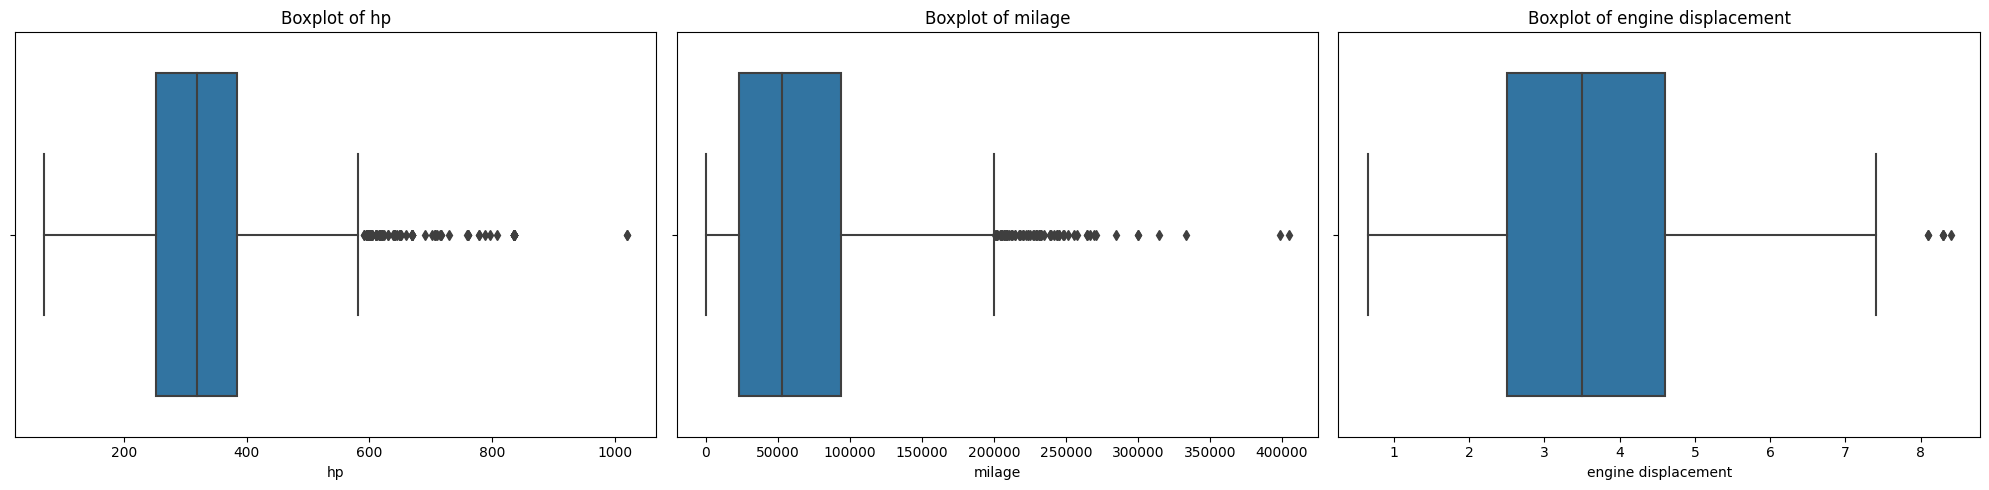

In [16]:
columns = ['hp', 'milage', 'engine displacement']

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes = axes.flatten()

for i, col in enumerate(columns):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel(f'{col}')

plt.tight_layout()
plt.show()
    

In [17]:
columns = ['engine displacement', 'hp', 'price', 'milage']
for col in columns:
    Q1 = df[col].quantile(0.25)  
    Q3 = df[col].quantile(0.75)   
    IQR = Q3 - Q1                    
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [18]:
df.shape

(3606, 15)

## Encoding Categorical Features

In [19]:
df['Accident_Impact'] = df['accident'].apply(lambda x: 1 if x == 'At least 1 accident or damage reported' else 0)

In [20]:
df['clean_title'] = df['clean_title'].apply(lambda x: 1 if x == 'Yes' else 0)

In [21]:
vis_df = df.copy()
vis_df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,hp,engine displacement,is_v_engine,Accident_Impact
0,Ford,Utility Police Interceptor Base,2013,51000,E85 FLEX FUEL,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,A/T,Black,Black,At least 1 accident or damage reported,1,10300,300.000000,3.7,True,1
1,Hyundai,Palisade SEL,2021,34742,GASOLINE,3.8L V6 24V GDI DOHC,A/T,Moonlight Cloud,Gray,At least 1 accident or damage reported,1,38005,246.700000,3.8,True,1
2,Lexus,RX 350 RX 350,2022,22372,GASOLINE,3.5 Liter DOHC,A/T,Blue,Black,None reported,0,54598,303.659259,3.5,False,0
3,INFINITI,Q50 Hybrid Sport,2015,88900,HYBRID,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,A/T,Black,Black,None reported,1,15500,354.000000,3.5,True,0
4,Audi,Q3 45 S line Premium Plus,2021,9835,GASOLINE,2.0L I4 16V GDI DOHC Turbo,A/T,Glacier White Metallic,Black,None reported,0,34999,318.831250,2.0,False,0


In [22]:
categorical_columns = ['fuel_type', 'transmission', 'is_v_engine']

for cat_col in categorical_columns:
    encoder = LabelEncoder()
    df[cat_col] = encoder.fit_transform(df[cat_col])

## Feature Engineering

In [23]:
df['Vehicle_Age'] = 2025 - df['model_year']

In [24]:
df['Mileage_per_Year'] = df.apply(
    lambda row: row['milage'] / row['Vehicle_Age'] if row['Vehicle_Age'] > 0 else row['milage'],
    axis=1
)

In [25]:
# Binning
df['Vehicle_Age_Bin'] = pd.qcut(df['Vehicle_Age'], q=4, labels=['New', 'Mid', 'Old', 'Very Old'])
df['Mileage_Bin'] = pd.qcut(df['milage'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# One-hot encode
df = pd.get_dummies(df, columns=['Vehicle_Age_Bin', 'Mileage_Bin'], prefix=['Age', 'Milage'], drop_first=True, dtype=int)

## Drop Unused Features

In [26]:
df.drop(['model', 'model_year', 'engine', 'milage', 'int_col', 'ext_col', 'accident'], axis = 1, inplace = True)

In [27]:
df.isnull().sum()

brand                  0
fuel_type              0
transmission           0
clean_title            0
price                  0
hp                     0
engine displacement    0
is_v_engine            0
Accident_Impact        0
Vehicle_Age            0
Mileage_per_Year       0
Age_Mid                0
Age_Old                0
Age_Very Old           0
Milage_Medium          0
Milage_High            0
Milage_Very High       0
dtype: int64

In [28]:
df.head()

,brand,fuel_type,transmission,clean_title,price,hp,engine displacement,is_v_engine,Accident_Impact,Vehicle_Age,Mileage_per_Year,Age_Mid,Age_Old,Age_Very Old,Milage_Medium,Milage_High,Milage_Very High
0,Ford,1,0,1,10300,300.000000,3.7,1,1,12,4250.000000,0,1,0,1,0,0
1,Hyundai,2,0,1,38005,246.700000,3.8,1,1,4,8685.500000,0,0,0,1,0,0
2,Lexus,2,0,0,54598,303.659259,3.5,0,0,3,7457.333333,0,0,0,0,0,0
3,INFINITI,3,0,1,15500,354.000000,3.5,1,0,10,8890.000000,0,1,0,0,1,0
4,Audi,2,0,0,34999,318.831250,2.0,0,0,4,2458.750000,0,0,0,0,0,0


# Data Visualization

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


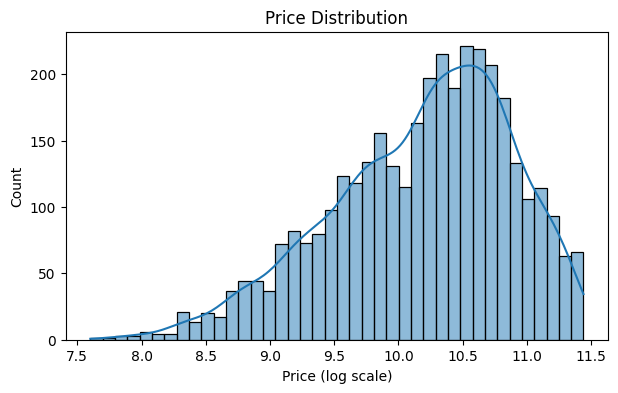

In [29]:
plt.figure(figsize=(7,4))
sns.histplot(np.log1p(df['price']), bins=40, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price (log scale)')
plt.ylabel('Count')
plt.show()

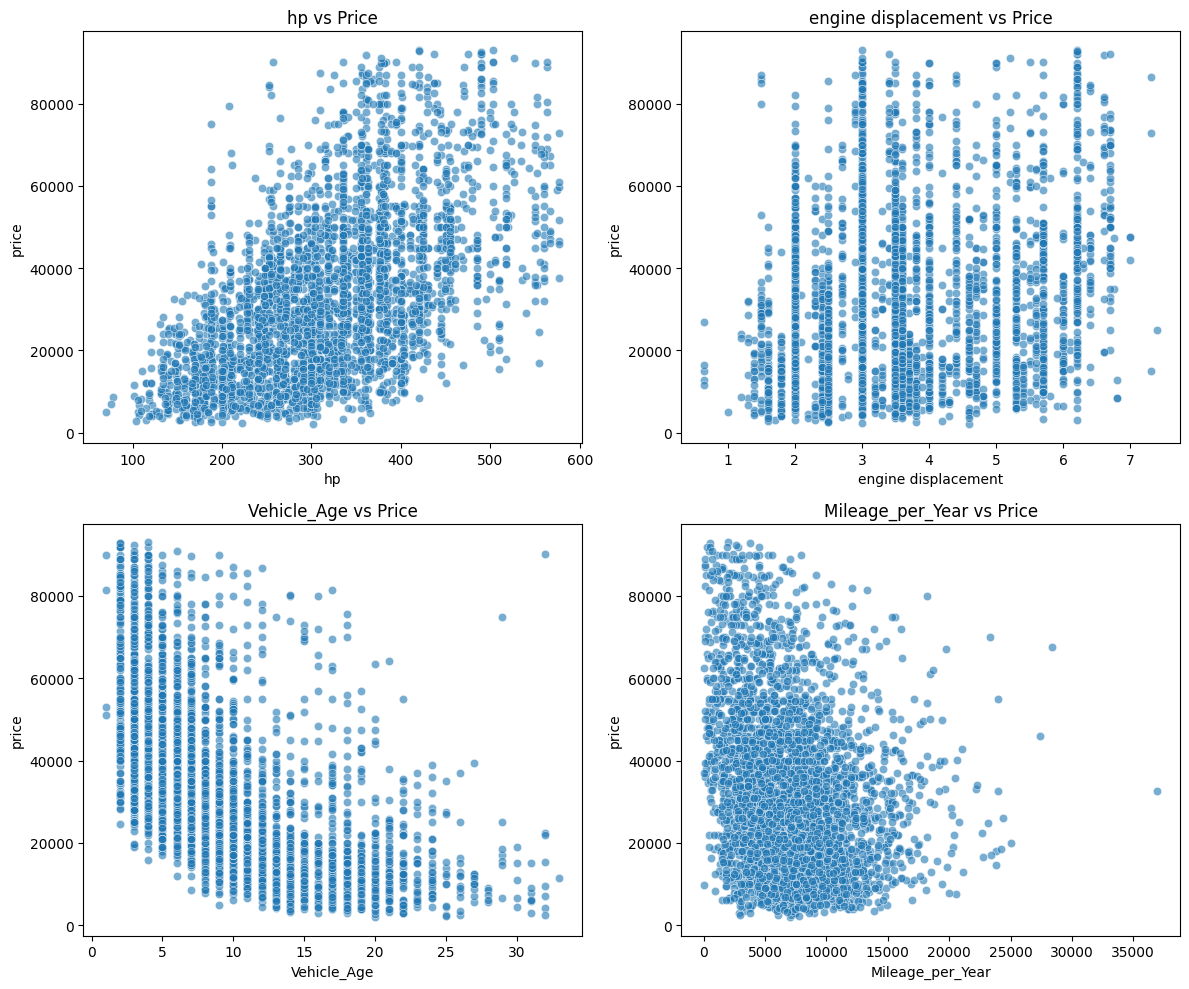

In [30]:
num_cols = ['hp','engine displacement','Vehicle_Age','Mileage_per_Year']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.scatterplot(x=df[col], y=df['price'], alpha=0.6, ax=axes[i])
    axes[i].set_title(f'{col} vs Price')

plt.tight_layout()
plt.show()

<Axes: >

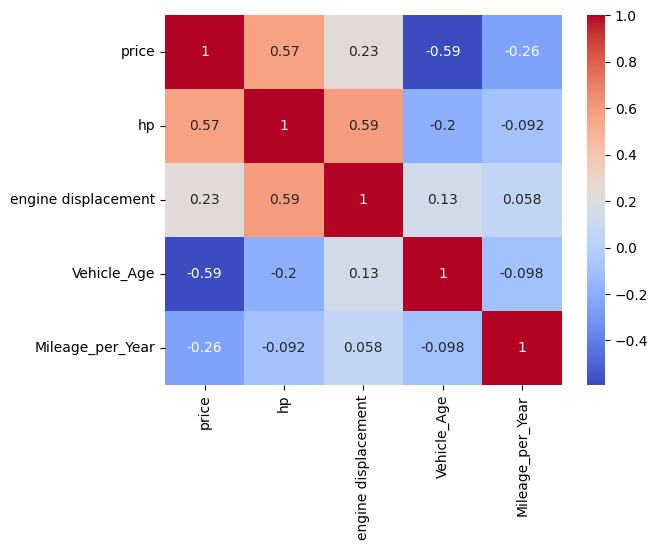

In [31]:
num_features = ['price','hp','engine displacement','Vehicle_Age','Mileage_per_Year']
sns.heatmap(df[num_features].corr(), annot=True, cmap='coolwarm')

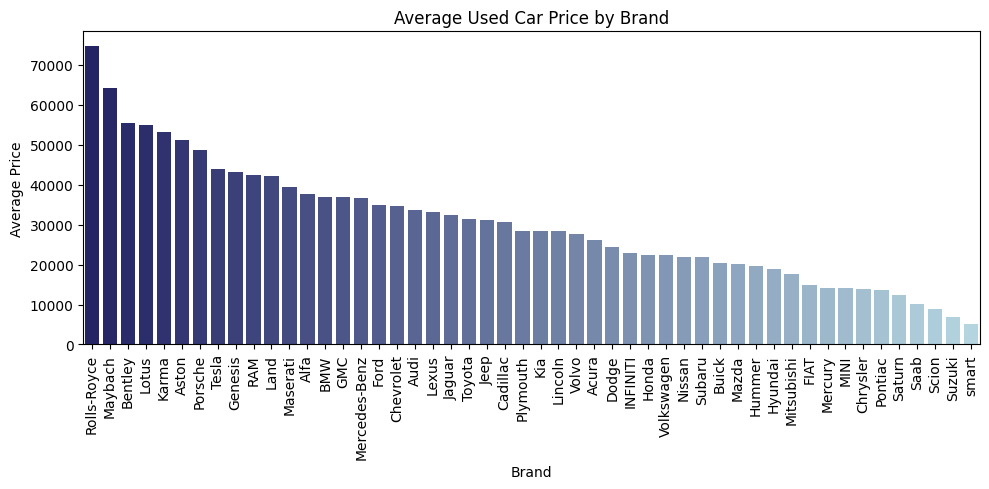

In [32]:
brand_avg_price = (
    vis_df.groupby('brand')['price']
      .mean()
      .sort_values(ascending=False)
)

plt.figure(figsize=(10,5))
sns.barplot(
    x=brand_avg_price.index,
    y=brand_avg_price.values,
    palette=sns.color_palette("blend:midnightblue,lightblue", n_colors=len(brand_avg_price)
))
plt.xticks(rotation=90)
plt.title("Average Used Car Price by Brand")
plt.xlabel("Brand")
plt.ylabel("Average Price")
plt.tight_layout()
plt.show()

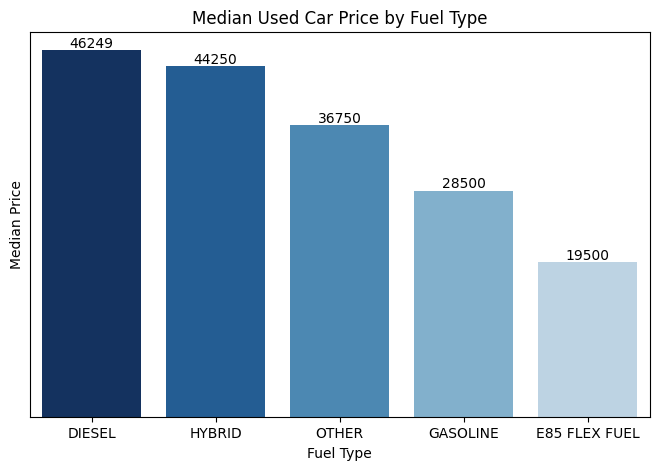

In [33]:
order = (
    vis_df.groupby('fuel_type')['price']
          .median()
          .sort_values(ascending=False)
          .index
)


medians = vis_df.groupby('fuel_type')['price'].median().loc[order]

# Color Grediant
cmap = plt.colormaps.get_cmap('Blues')
colors = [cmap(x) for x in np.linspace(1, 0.3, len(medians))]

plt.figure(figsize=(8,5))
ax = sns.barplot(
    x='fuel_type',
    y='price',
    data=vis_df,
    order=order,
    estimator=np.median,
    errorbar=None,
    palette=colors
)

plt.title("Median Used Car Price by Fuel Type")
plt.xlabel("Fuel Type")
ax.set_ylabel("Median Price")
ax.set_yticks([])   


for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.0f}',
        (p.get_x() + p.get_width()/2, p.get_height()),
        ha='center', va='bottom', fontsize=10, color='black'
    )

plt.show()

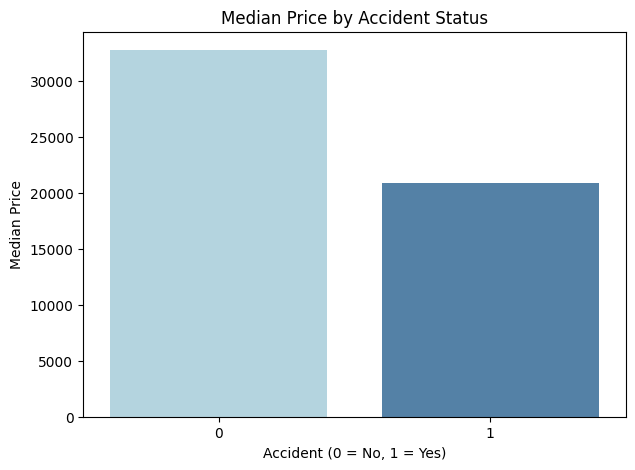

In [34]:
plt.figure(figsize=(7,5))

sns.barplot(
    x='Accident_Impact',
    y='price',
    data=vis_df,
    estimator=np.median,   
    errorbar=None,
    palette= ['lightblue','steelblue']
)

plt.title("Median Price by Accident Status")
plt.xlabel("Accident (0 = No, 1 = Yes)")
plt.ylabel("Median Price")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_36/1089217733.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


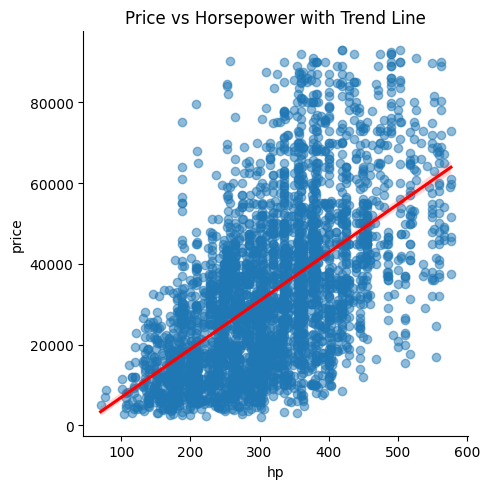

In [35]:
sns.lmplot(data=df, x='hp', y='price', line_kws={'color':'red'}, scatter_kws={'alpha':0.5})
plt.title('Price vs Horsepower with Trend Line')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


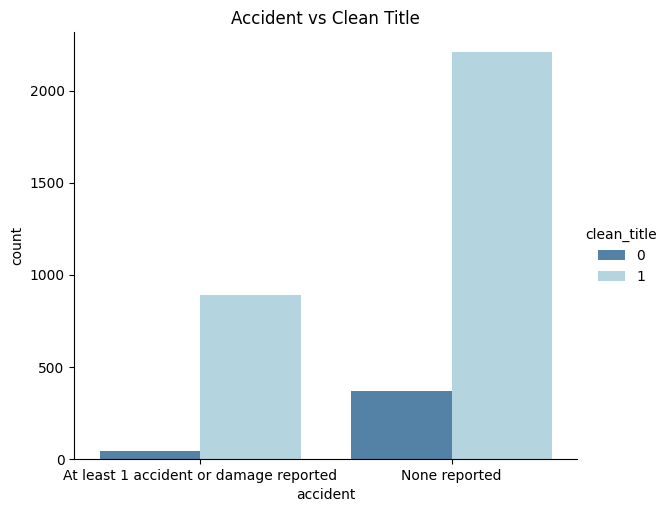

In [36]:
acc_ct = vis_df.groupby(['accident','clean_title']).size().reset_index(name='count')
sns.catplot(data=acc_ct, x='accident', y='count', hue='clean_title',
            kind='bar', height=5, aspect=1.2,
            palette = ["steelblue","lightblue"]
            )
plt.title('Accident vs Clean Title')
plt.show()

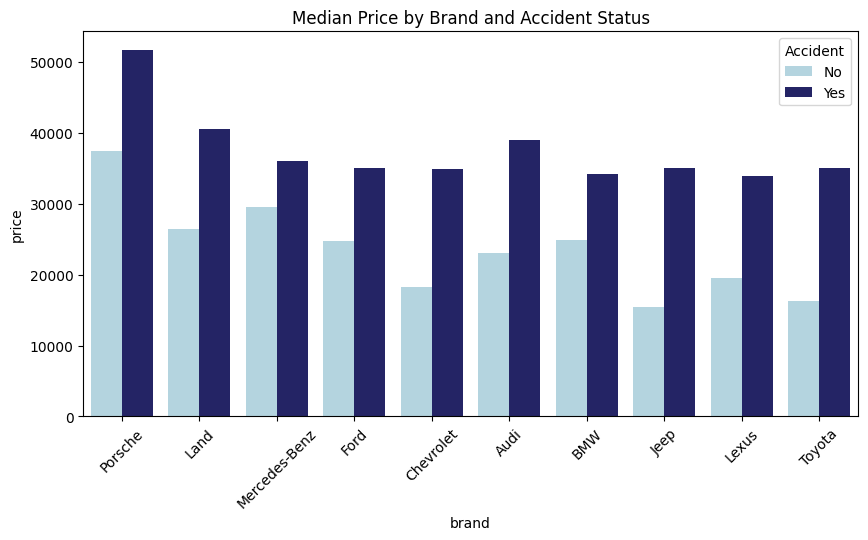

In [37]:
top_brands = vis_df['brand'].value_counts().nlargest(10).index

brand_order = (
    vis_df[vis_df['brand'].isin(top_brands)]
    .groupby('brand')['price']
    .median()
    .sort_values(ascending=False)
    .index
)

plt.figure(figsize=(10,5))
ax = sns.barplot(
    data=vis_df[vis_df['brand'].isin(top_brands)],
    x='brand',
    y='price',
    hue='accident',
    estimator=np.median,
    errorbar=None,
    order=brand_order,
    palette=['lightblue','midnightblue']   
)

plt.title('Median Price by Brand and Accident Status')
plt.xticks(rotation=45)

ax.legend(title="Accident", labels=["No", "Yes"])

plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

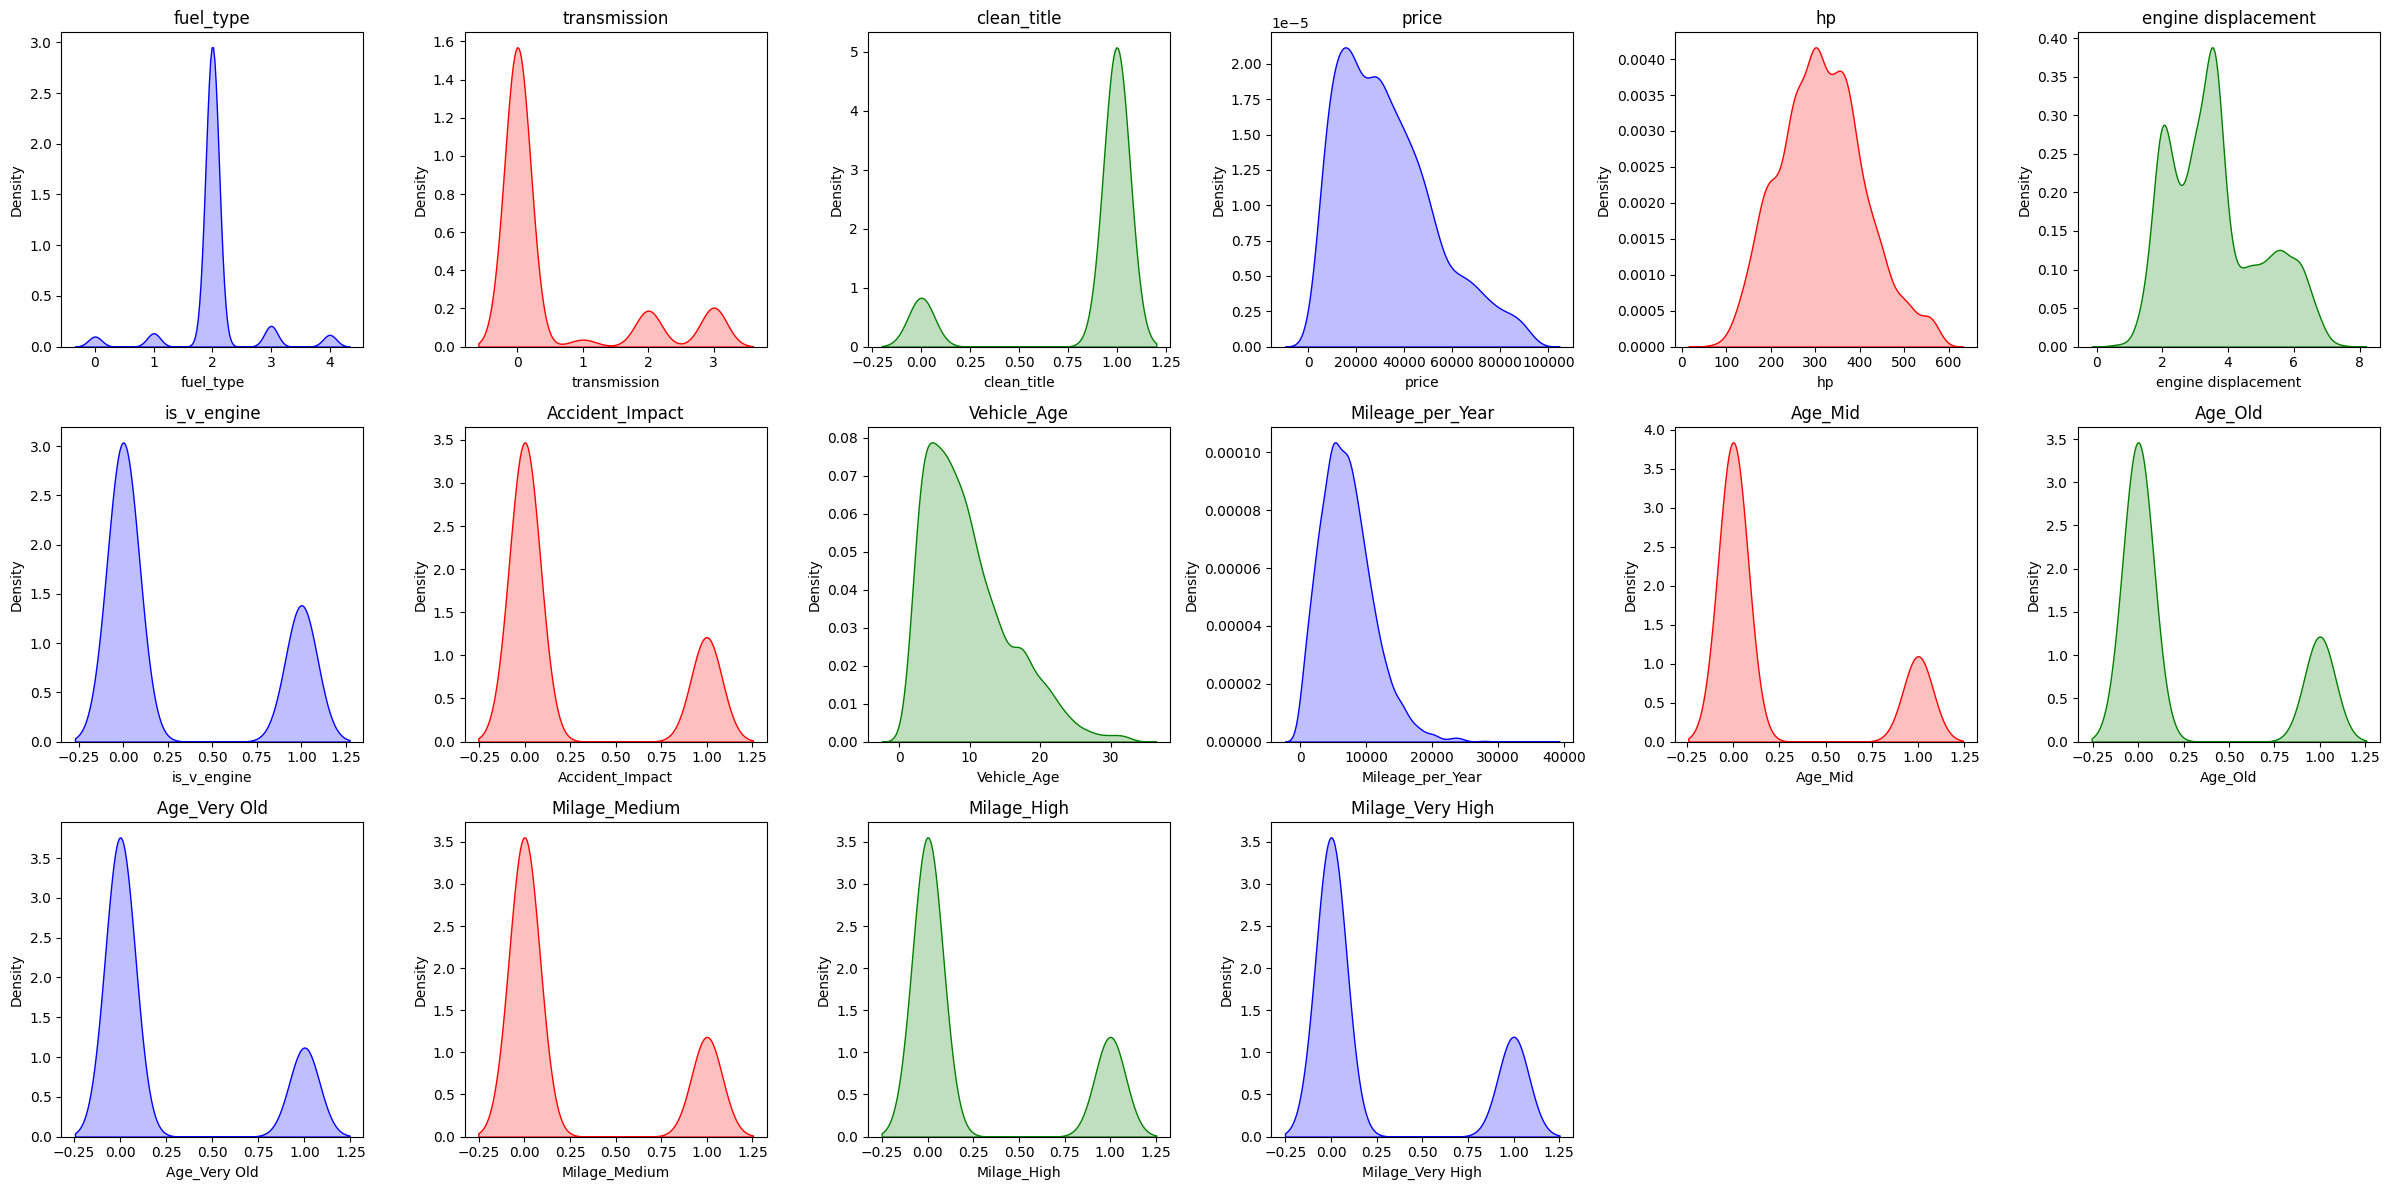

In [38]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

n_rows = 3
numeric_column_name = df.select_dtypes(include='number').columns
n_cols = int(np.ceil(len(numeric_column_name)/n_rows))
colors = ['blue', 'red', 'green']

plt.figure(figsize=(4*n_cols, 4*n_rows))
for idx, column in enumerate(numeric_column_name, 1):
    plt.subplot(n_rows, n_cols, idx)
    sns.kdeplot(
        data=df,
        x=column,
        fill=True,                      
        color=colors[(idx-1) % len(colors)]  
    )
    plt.title(column)
plt.tight_layout()
plt.show()

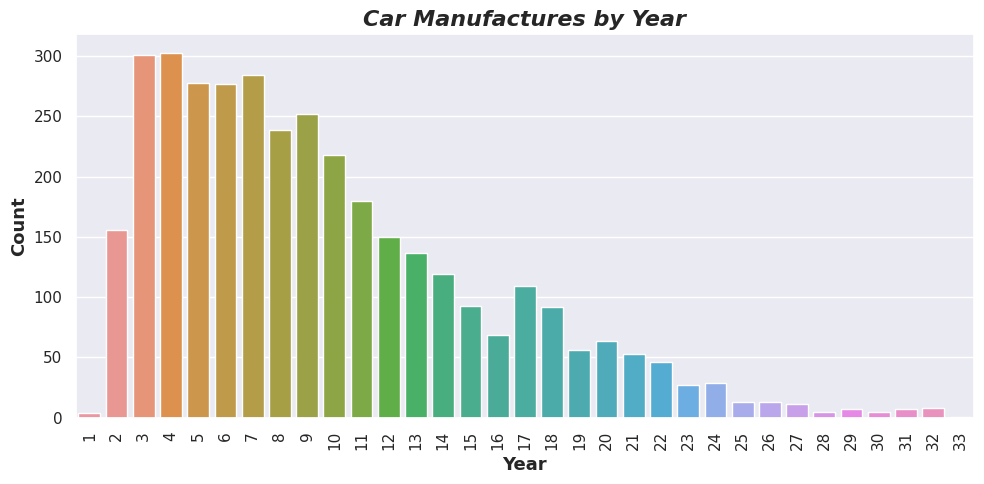

In [74]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='Vehicle_Age', width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Year', fontdict={'family': 'Times New Roman', 'size':13, 'weight': 'bold'})
plt.ylabel('Count', fontdict={'family': 'Times New Roman', 'size':13, 'weight': 'bold'})
plt.title('Car Manufactures by Year', fontdict={'family': 'Times New Roman', 'style': 'oblique', 'size':16, 'weight': 'bold'})
sns.set_style('darkgrid')
sns.set_theme('notebook')
plt.tight_layout()
plt.show()

# Model Building and Evaluation

## Import Libraries

In [40]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

## Split the data (Features, Target)

In [41]:
X = df.drop(['price'], axis = 1)
y = df['price']
y_log = np.log1p(y)

## Split the data (Train, Test)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,y_log,test_size=0.2, random_state=42, shuffle=True)

## Target Encoding For Brand

In [43]:
brand_target_mean = X_train.join(y_train).groupby('brand')['price'].mean()

X_train['brand_encoded'] = X_train['brand'].map(brand_target_mean)
X_test['brand_encoded'] = X_test['brand'].map(brand_target_mean)

X_test['brand_encoded'] = X_test['brand_encoded'].fillna(y_train.mean())

X_train = X_train.drop(columns=['brand'])
X_test = X_test.drop(columns=['brand'])

## Features Scaling

In [44]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Linear Regression Model

### Model Training - Prediction

In [45]:
linearModel = LinearRegression()
linearModel.fit(X_train_scaled, y_train)

y_train_pred_log = linearModel.predict(X_train_scaled)
y_train_pred = np.expm1(y_train_pred_log)

y_test_pred_log = linearModel.predict(X_test_scaled)
y_test_pred = np.expm1(y_test_pred_log)

y_train_real = np.expm1(y_train)
y_test_real = np.expm1(y_test)

### Model Evaluation

In [46]:
lr_train_mae = mean_absolute_error(y_train_real, y_train_pred)
lr_test_mae = mean_absolute_error(y_test_real, y_test_pred)

print(f"MAE Training: {lr_train_mae:.2f}")
print(f"MAE Testing: {lr_test_mae:.2f}")

MAE Training: 7372.94
MAE Testing: 7916.08


In [47]:
lr_rmse_train = np.sqrt(mean_squared_error(y_train_real, y_train_pred))
lr_rmse_test = np.sqrt(mean_squared_error(y_test_real, y_test_pred))

print(f"RMSE Training: {lr_rmse_test}")
print(f"RMSE Testing: {lr_rmse_train}")

RMSE Training: 11664.237572847433
RMSE Testing: 10770.809426268033


In [48]:
lr_train_r2 = r2_score(y_train_real, y_train_pred)
lr_test_r2 = r2_score(y_test_real, y_test_pred)

print(f"R² Training: {lr_train_r2:.2f}")
print(f"R² Testing: {lr_test_r2:.2f}")

R² Training: 0.71
R² Testing: 0.66


## Random Forest Regressor

### Hyperparameter Tuning

In [49]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [8, 10, 12],
    'min_samples_split': [5, 10, 15], 
    'min_samples_leaf': [2, 4, 6],  
    'max_features': ['sqrt']
}

scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'RMSE': make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False),
                        greater_is_better=False),
    'R2': make_scorer(r2_score)
}

### Model Training - Prediction

In [50]:
rf_model = RandomForestRegressor(random_state=40)

kf = KFold(n_splits=7, shuffle=True, random_state=42)

rf_grid = GridSearchCV(rf_model, param_grid, scoring=scoring, refit='RMSE', cv=kf, n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)

print("✅ Best parameters from CV:", rf_grid.best_params_)

✅ Best parameters from CV: {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}


In [51]:
best_rf_model = rf_grid.best_estimator_

y_train_pred_log = best_rf_model.predict(X_train_scaled)
y_train_pred = np.expm1(y_train_pred_log)

y_test_pred_log = best_rf_model.predict(X_test_scaled)
y_test_pred = np.expm1(y_test_pred_log)

y_test_real = np.expm1(y_test)
y_train_real = np.expm1(y_train)

### Cross Validation - Error Analysis

In [52]:
rf_cv_results = pd.DataFrame(rf_grid.cv_results_)
cols = ['param_n_estimators','param_max_depth','param_min_samples_split', 'param_min_samples_leaf', 'param_max_features',
        'mean_test_R2','mean_test_MAE','mean_test_RMSE']

rf_cv_results[cols].sort_values(by='mean_test_RMSE',ascending=False).head(10)

,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,mean_test_R2,mean_test_MAE,mean_test_RMSE
56,300,12,5,2,sqrt,0.823214,-0.217027,-0.294330
55,200,12,5,2,sqrt,0.822540,-0.217523,-0.294887
54,100,12,5,2,sqrt,0.822363,-0.217901,-0.295066
58,200,12,10,2,sqrt,0.820836,-0.219126,-0.296283
59,300,12,10,2,sqrt,0.820565,-0.219347,-0.296513
57,100,12,10,2,sqrt,0.819862,-0.219716,-0.297038
28,200,10,5,2,sqrt,0.818824,-0.221185,-0.297971
29,300,10,5,2,sqrt,0.818712,-0.221173,-0.298033
27,100,10,5,2,sqrt,0.817620,-0.222037,-0.298933
62,300,12,15,2,sqrt,0.817717,-0.221023,-0.298935


In [53]:
rf_errors = pd.DataFrame({
    'Actual': y_test_real,
    'Predicted': y_test_pred,
    'Absolute Error': np.abs(y_test_real - y_test_pred)
})

rf_worst_cases = rf_errors.sort_values(by='Absolute Error', ascending=False).head(10)
print("\nWorst 10 predictions:")
rf_worst_cases


Worst 10 predictions:


,Actual,Predicted,Absolute Error
2303,90200.0,8602.097889,81597.902111
384,75000.0,19876.521910,55123.478090
293,86999.0,35537.775152,51461.224848
2063,80300.0,39253.323090,41046.676910
209,65998.0,31291.975780,34706.024220
3429,67000.0,32720.856311,34279.143689
1521,80140.0,49018.904476,31121.095524
484,85500.0,54822.056837,30677.943163
506,87500.0,56873.586819,30626.413181
139,86900.0,56476.423214,30423.576786


### Model Evaluation

In [54]:
rf_train_mae = mean_absolute_error(y_train_real, y_train_pred)
rf_test_mae = mean_absolute_error(y_test_real, y_test_pred)

print(f"MAE Training: {rf_train_mae:.2f}")
print(f"MAE Testing: {rf_test_mae:.2f}")

MAE Training: 4476.20
MAE Testing: 6259.30


In [55]:
rf_train_rmse = np.sqrt(mean_squared_error(y_train_real, y_train_pred))
rf_test_rmse = np.sqrt(mean_squared_error(y_test_real, y_test_pred))

print(f"RMSE Training: {rf_train_rmse:.2f}")
print(f"RMSE Testing: {rf_test_rmse:.2f}")

RMSE Training: 6801.13
RMSE Testing: 9446.60


In [56]:
rf_train_r2 = r2_score(y_train_real, y_train_pred)  
rf_test_r2 = r2_score(y_test_real, y_test_pred)

print(f"R² Training: {rf_train_r2:.2f}")
print(f"R² Testing: {rf_test_r2:.2f}")

R² Training: 0.88
R² Testing: 0.77


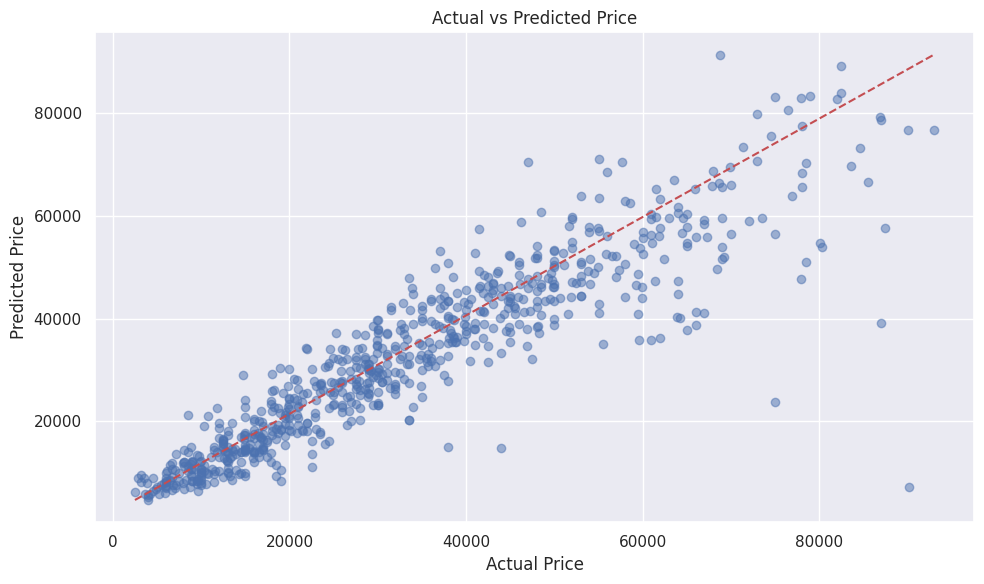

In [81]:
plt.figure(figsize=(10,6))
plt.scatter(y_test_real, y_test_pred, alpha=0.5)
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_pred.min(), y_test_pred.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")

plt.tight_layout()
plt.show()

## Support Vector Regressor 

### Hyperparameter Tuning

In [57]:
svr_param_grid = {
    "C" : [0.1, 1, 10, 100],
    "epsilon" : [0.01, 0.1, 0.2, 0.5],
    "kernel": ["linear", "rbf"],
    "gamma" : ["scale", "auto"]
}

scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'RMSE': make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False),
                        greater_is_better=False),
    'R2': make_scorer(r2_score)
}

kf = KFold(n_splits=7, shuffle=True, random_state=42)

svr = SVR()

svr_grid_search = GridSearchCV(
    estimator=svr,
    param_grid=svr_param_grid,
    scoring=scoring,
    refit='RMSE',
    cv=kf,
    n_jobs=-1,
    verbose=0
)

### Model Training - Prediction

In [58]:
svr_grid_search.fit(X_train_scaled, y_train)

best_svr_model = svr_grid_search.best_estimator_
print("\nBest SVR params:", svr_grid_search.best_params_)


Best SVR params: {'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}


In [59]:
y_train_pred_log = best_svr_model.predict(X_train_scaled)
y_train_pred = np.expm1(y_train_pred_log)

y_test_pred_log = best_svr_model.predict(X_test_scaled)
y_test_pred = np.expm1(y_test_pred_log)

y_train_real = np.expm1(y_train)
y_test_real = np.expm1(y_test)

### Cross Validation - Error Analysis

In [60]:
svr_cv_results = pd.DataFrame(svr_grid_search.cv_results_)
cols = ['param_C','param_epsilon','param_kernel', 'param_gamma',
        'mean_test_R2','mean_test_MAE','mean_test_RMSE']

svr_cv_results[cols].sort_values(by='mean_test_RMSE',ascending=False).head(10)

,param_C,param_epsilon,param_kernel,param_gamma,mean_test_R2,mean_test_MAE,mean_test_RMSE
21,1,0.1,rbf,scale,0.817606,-0.220468,-0.299078
23,1,0.1,rbf,auto,0.817591,-0.220479,-0.299091
19,1,0.01,rbf,auto,0.815086,-0.221598,-0.301122
17,1,0.01,rbf,scale,0.815077,-0.221610,-0.301130
27,1,0.2,rbf,auto,0.813844,-0.224943,-0.302143
25,1,0.2,rbf,scale,0.813816,-0.224965,-0.302166
39,10,0.1,rbf,auto,0.803234,-0.229397,-0.310797
37,10,0.1,rbf,scale,0.803195,-0.229400,-0.310834
43,10,0.2,rbf,auto,0.800143,-0.233380,-0.313171
41,10,0.2,rbf,scale,0.800112,-0.233392,-0.313198


In [61]:
svr_errors = pd.DataFrame({
    'Actual': y_test_real,
    'Predicted': y_test_pred,
    'Absolute Error': np.abs(y_test_real - y_test_pred)
})

svr_worst_cases = svr_errors.sort_values(by='Absolute Error', ascending=False).head(10)
print("\nWorst 10 predictions:")
svr_worst_cases


Worst 10 predictions:


,Actual,Predicted,Absolute Error
2303,90200.0,4396.328729,85803.671271
384,75000.0,22419.092407,52580.907593
293,86999.0,42731.393865,44267.606135
2063,80300.0,42939.409277,37360.590723
506,87500.0,54581.023169,32918.976831
3429,67000.0,35633.072146,31366.927854
483,93000.0,61811.341623,31188.658377
1521,80140.0,49261.420442,30878.579558
3409,84620.0,54682.010199,29937.989801
139,86900.0,57082.938959,29817.061041


### Model Evaluation

In [62]:
svr_train_mae = mean_absolute_error(y_train_real, y_train_pred)
svr_test_mae = mean_absolute_error(y_test_real, y_test_pred)

print(f"MAE Training: {svr_train_mae:.2f}")
print(f"MAE Testing: {svr_test_mae:.2f}")

MAE Training: 5157.65
MAE Testing: 6461.38


In [63]:
svr_train_rmse = np.sqrt(mean_squared_error(y_train_real, y_train_pred))
svr_test_rmse = np.sqrt(mean_squared_error(y_test_real, y_test_pred))

print(f"RMSE Training: {svr_train_rmse:.2f}")
print(f"RMSE Testing: {svr_test_rmse:.2f}")

RMSE Training: 7806.96
RMSE Testing: 9756.67


In [64]:
svr_train_r2 = r2_score(y_train_real, y_train_pred)  
svr_test_r2 = r2_score(y_test_real, y_test_pred)

print(f"R² Training: {svr_train_r2:.2f}")
print(f"R² Testing: {svr_test_r2:.2f}")

R² Training: 0.85
R² Testing: 0.76


In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(y_test_real, y_test_pred, alpha=0.5)
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_pred.min(), y_test_pred.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")

plt.tight_layout()
plt.show()

## XGBoost Regressor

### Hyperparameter Tuning

In [65]:
param_grid_xgb = {
    'n_estimators': [100, 200, 300],  
    'learning_rate': [0.01, 0.03],  
    'max_depth': [5, 7], 
    'subsample': [0.7, 0.9],  
    'colsample_bytree': [0.6, 0.8],  
    'reg_lambda': [1, 10],  
    'reg_alpha': [0, 1]    
}

scoring = {
    'R2': 'r2',
    'MAE': 'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error'
}

kf = KFold(n_splits=7, shuffle=True, random_state=42)  

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=40, early_stopping_rounds=30)

grid_xgb = GridSearchCV(
    xgb_model,
    param_grid_xgb,
    scoring=scoring,
    refit='RMSE',
    cv=kf,
    n_jobs=-1,
    verbose=1
)

### Model Training - Prediction

In [66]:
grid_xgb.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_test_scaled, y_test)],  
    verbose=False  
)

best_xgb_model = grid_xgb.best_estimator_
print("Best parameters:", grid_xgb.best_params_)

Fitting 7 folds for each of 192 candidates, totalling 1344 fits
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.9}


In [67]:
y_train_pred_log = best_xgb_model.predict(X_train_scaled)
y_train_pred = np.expm1(y_train_pred_log)

y_test_pred_log = best_xgb_model.predict(X_test_scaled)
y_test_pred = np.expm1(y_test_pred_log)

y_test_real = np.expm1(y_test)
y_train_real = np.expm1(y_train)

### Cross Validation - Error Analysis

In [68]:
xgb_cv_results = pd.DataFrame(grid_xgb.cv_results_)
cols = ['param_n_estimators','param_learning_rate','param_max_depth', 'param_subsample', 'param_colsample_bytree', 'param_reg_lambda', 'param_reg_alpha',
        'mean_test_R2','mean_test_MAE','mean_test_RMSE']

xgb_cv_results[cols].sort_values(by='mean_test_RMSE',ascending=False).head(10)

,param_n_estimators,param_learning_rate,param_max_depth,param_subsample,param_colsample_bytree,param_reg_lambda,param_reg_alpha,mean_test_R2,mean_test_MAE,mean_test_RMSE
89,300,0.03,7,0.9,0.6,1,0,0.857208,-0.191576,-0.264520
184,300,0.03,7,0.7,0.8,1,0,0.856767,-0.192496,-0.264850
185,300,0.03,7,0.9,0.8,1,0,0.856548,-0.191987,-0.265042
88,300,0.03,7,0.7,0.6,1,0,0.856693,-0.192587,-0.265045
93,300,0.03,7,0.9,0.6,1,1,0.854974,-0.194362,-0.266581
91,300,0.03,7,0.9,0.6,10,0,0.854668,-0.194870,-0.266925
92,300,0.03,7,0.7,0.6,1,1,0.854482,-0.194734,-0.267097
186,300,0.03,7,0.7,0.8,10,0,0.854230,-0.195267,-0.267321
90,300,0.03,7,0.7,0.6,10,0,0.854004,-0.195458,-0.267533
187,300,0.03,7,0.9,0.8,10,0,0.853542,-0.194941,-0.267831


In [69]:
xgb_errors = pd.DataFrame({
    'Actual': y_test_real,
    'Predicted': y_test_pred,
    'Absolute Error': np.abs(y_test_real - y_test_pred)
})

xgb_worst_cases = xgb_errors.sort_values(by='Absolute Error', ascending=False).head(10)
print("\nWorst 10 predictions:")
xgb_worst_cases


Worst 10 predictions:


,Actual,Predicted,Absolute Error
2303,90200.0,7174.621582,83025.378418
384,75000.0,23813.267578,51186.732422
293,86999.0,39156.898438,47842.101562
1655,77900.0,47657.089844,30242.910156
506,87500.0,57648.191406,29851.808594
2602,44000.0,14897.721680,29102.278320
244,78499.0,50941.183594,27557.816406
209,65998.0,38803.769531,27194.230469
1273,64995.0,37824.800781,27170.199219
2063,80300.0,53920.093750,26379.906250


### Model Evaluation

In [70]:
xgb_train_mae = mean_absolute_error(y_train_real, y_train_pred)
xgb_test_mae = mean_absolute_error(y_test_real, y_test_pred)

print(f"MAE Training: {xgb_train_mae:.2f}")
print(f"MAE Testing: {xgb_test_mae:.2f}")

MAE Training: 3002.74
MAE Testing: 5231.40


In [71]:
xgb_train_rmse = np.sqrt(mean_squared_error(y_train_real, y_train_pred))
xgb_test_rmse = np.sqrt(mean_squared_error(y_test_real, y_test_pred))

print(f"RMSE Training: {xgb_train_rmse:.2f}")
print(f"RMSE Testing: {xgb_test_rmse:.2f}")

RMSE Training: 4424.63
RMSE Testing: 8176.96


In [72]:
xgb_train_r2 = r2_score(y_train_real, y_train_pred)  
xgb_test_r2 = r2_score(y_test_real, y_test_pred)

print(f"R² Training: {xgb_train_r2:.2f}")
print(f"R² Testing: {xgb_test_r2:.2f}")

R² Training: 0.95
R² Testing: 0.83


In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(y_test_real, y_test_pred, alpha=0.5)
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_pred.min(), y_test_pred.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")

plt.tight_layout()
plt.show()

Feature Importances:
 Age_Old                0.331742
Milage_High            0.247166
Accident_Impact        0.134592
Age_Mid                0.057857
clean_title            0.051933
Milage_Medium          0.037628
Milage_Very High       0.025798
hp                     0.021137
Vehicle_Age            0.016634
Mileage_per_Year       0.016410
brand                  0.014562
Age_Very Old           0.014545
fuel_type              0.009748
engine displacement    0.009112
is_v_engine            0.005996
transmission           0.005140
dtype: float32


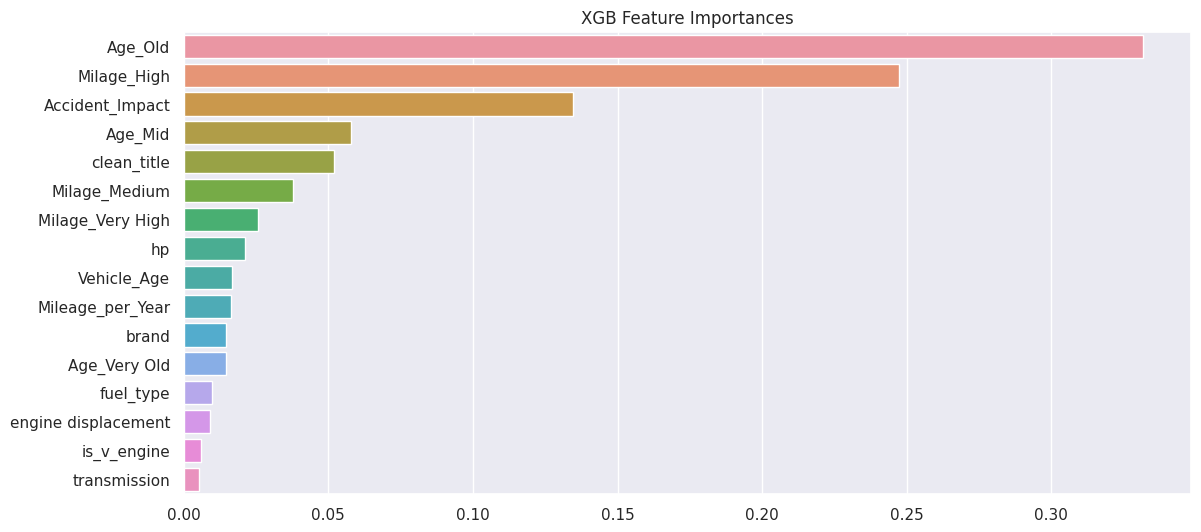

In [73]:
importances = pd.Series(best_xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importances:\n", importances)
plt.figure(figsize=(13,6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("XGB Feature Importances")
plt.show()

# Summary

### 📌 Project Summary

This project focuses on predicting used car prices using machine learning models trained on historical data. We explored multiple regression models, applied feature engineering, and evaluated model performance using MAE, RMSE, R² to identify the best performer.

---

### ✅ Models Trained & Compared

| Model                    | Test RMSE | Test R²  | perdict          |
|--------------------------|-----------|----------|------------------|
| Linear Regression        | ~10770.80 | 0.66     | Overfitting ❌   |
| Random Forest            | ~9446.60  | 0.77     | Good ✅          |
| Support Vector Regressor | ~9756.67  | 0.76     | Good ✅          |
| XGBoost                  | ~8176.96  | 0.83     | Best ✅✅        |

**XGBoost** showed the best performance, achieving the lowest RMSE, the highest R² which reflects superior accuracy and generalization.